In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr#皮尔逊
from scipy.stats import spearmanr#斯皮尔曼
import seaborn as sns#绘制热力图
from sklearn.cluster import KMeans#导入Kmeans算法
plt.rcParams["font.sans-serif"] = ["SimHei"] # 设置字体
plt.rcParams["axes.unicode_minus"] = False # 该语句解决图像中的“-”负号的乱码问题
from scipy.stats import kstest#Kolmogorov-Smirnov 正态性检验

# 数据清洗

## 1导入数据并更改数据列名

In [2]:
data = pd.read_csv('./order_train1.csv')#导入数据
data.columns=['订单日期','销售区域编码','产品编码','产品大类编码','产品细类编码','销售渠道名称','产品价格','订单需求量']#更改数据列名
data

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量
0,2015-09-01,104,22069,307,403,offline,1114.0,19
1,2015-09-01,104,20028,301,405,offline,1012.0,12
2,2015-09-02,104,21183,307,403,online,428.0,109
3,2015-09-02,104,20448,308,404,online,962.0,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3
...,...,...,...,...,...,...,...,...
597689,2018-12-20,102,20994,302,408,offline,843.0,59
597690,2018-12-20,102,21875,302,408,offline,762.0,502
597691,2018-12-20,102,20215,302,408,offline,2013.0,106
597692,2018-12-20,102,20195,302,408,offline,2120.0,187


## 2去除重复值

In [3]:
data=data.drop_duplicates()#去除重复值
data
#发现312条重复数据，我们认为针对于订单数据，重复值是人为的记录错误，故将其剔除，只保留一份数据

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量
0,2015-09-01,104,22069,307,403,offline,1114.0,19
1,2015-09-01,104,20028,301,405,offline,1012.0,12
2,2015-09-02,104,21183,307,403,online,428.0,109
3,2015-09-02,104,20448,308,404,online,962.0,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3
...,...,...,...,...,...,...,...,...
597689,2018-12-20,102,20994,302,408,offline,843.0,59
597690,2018-12-20,102,21875,302,408,offline,762.0,502
597691,2018-12-20,102,20215,302,408,offline,2013.0,106
597692,2018-12-20,102,20195,302,408,offline,2120.0,187


## 3数据扩展

In [4]:
#提取时间中的年、月、日，将销售渠道进行编码，线上用0表示，线下用1表示
data['订单日期'] = pd.to_datetime(data['订单日期'])
data['年'] = data['订单日期'].dt.year
data['月'] = data['订单日期'].dt.month
data['日'] = data['订单日期'].dt.day
replace_dict = {'offline': 1, 'online': 0}
data['销售渠道名称'] = data['销售渠道名称'].replace(replace_dict)

#对日期进行进一步剖析，添加促销日、季节、星期、工作日、上中下旬、节日信息，以便后续数据的分析及模型训练
def mark_date(date):
    if date.month == 6 and date.day == 18:
        return 1
    elif date.month == 11 and date.day == 11:
        return 1
    elif date.month == 11 and date.day == 11:
        return 1
    else:
        return 0
def get_season(date):
    if date.month in [3, 4, 5]:
        return '1'#春
    elif date.month in [6, 7, 8]:
        return '2'#夏
    elif date.month in [9, 10, 11]:
        return '3'#秋
    else:
        return '4'#冬
data['是否促销日'] = data['订单日期'].apply(mark_date)
data['季节']=data['订单日期'].apply(get_season)
data['星期'] = data['订单日期'].dt.weekday+1
data['是否工作日'] = data['星期'].isin(range(1, 6)).astype(int)
def get_xun(date):
    if date.day in range(1,11):
        return '1'#上
    elif date.day in range(11,21):
        return '2'#中
    elif date.day in range(21,32):
        return '3'#下
data['上中下旬']=data['订单日期'].apply(get_xun)
holiday_list = ['2015-09-27','2015-10-2','2015-10-3','2015-10-4','2015-10-5','2015-10-6','2015-10-7','2015-10-1','2016-1-1','2016-1-2','2016-1-3','2016-2-7'
               ,'2016-2-8','2016-2-9','2016-2-10','2016-2-11','2016-2-12','2016-2-13','2016-4-2','2016-4-3','2016-4-4','2016-4-30','2016-5-1','2016-5-2','2016-6-9','2016-6-10','2016-6-11'
               ,'2016-9-15','2016-9-16','2016-9-17','2016-10-3','2016-10-4','2016-10-5','2016-10-6','2016-10-7','2016-10-1','2016-10-2'
                ,'2017-1-1','2017-1-2','2016-12-31','2017-1-27','2017-1-28','2017-1-29','2017-1-30','2017-1-31','2017-2-1','2017-2-2','2017-4-2','2017-4-3','2017-4-4'
                ,'2017-5-1','2017-4-29','2017-4-30','2017-5-28','2017-5-29','2017-5-30','2017-10-2','2017-10-3','2017-10-4','2017-10-5'
                ,'2017-10-6','2017-10-7','2017-10-1','2017-10-8','2017-12-30','2017-12-31','2018-1-1','2018-2-15','2018-2-16','2018-2-17','2018-2-18'
                ,'2018-2-19','2018-2-20','2018-2-21','2018-4-5','2018-4-6','2018-4-7','2018-4-29','2018-4-30','2018-5-1'
                ,'2018-6-16','2018-6-17','2018-6-18','2018-9-22','2018-9-23','2018-9-24','2018-10-2'
                ,'2018-10-3','2018-10-4','2018-10-5','2018-10-6','2018-10-7','2018-10-1']
tiaoxiu_of_holiday=['2015-10-10','2016-2-6','2016-2-14','2016-6-12','2016-9-18','2016-10-8'
                    ,'2016-10-9','2017-1-22','2017-2-4','2017-4-1','2017-5-27','2017-9-30'
                    ,'2018-2-11','2018-2-24','2018-4-8','2018-4-28','2018-9-29','2018-9-30']
data['是否节假日'] = data['订单日期'].astype(str).isin(holiday_list).astype(int)
data.loc[(data['订单日期'].isin(holiday_list)) , '是否工作日'] = 0
data.loc[(data['订单日期'].isin(tiaoxiu_of_holiday)) , '是否工作日'] = 1

C:\Users\86136\AppData\Local\Temp\ipykernel_15544\2277868625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['订单日期'] = pd.to_datetime(data['订单日期'])
C:\Users\86136\AppData\Local\Temp\ipykernel_15544\2277868625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['年'] = data['订单日期'].dt.year
C:\Users\86136\AppData\Local\Temp\ipykernel_15544\2277868625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [5]:
data

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,年,月,日,是否促销日,季节,星期,是否工作日,上中下旬,是否节假日
0,2015-09-01,104,22069,307,403,1,1114.0,19,2015,9,1,0,3,2,1,1,0
1,2015-09-01,104,20028,301,405,1,1012.0,12,2015,9,1,0,3,2,1,1,0
2,2015-09-02,104,21183,307,403,0,428.0,109,2015,9,2,0,3,3,1,1,0
3,2015-09-02,104,20448,308,404,0,962.0,3,2015,9,2,0,3,3,1,1,0
4,2015-09-02,104,21565,307,403,1,1400.0,3,2015,9,2,0,3,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597689,2018-12-20,102,20994,302,408,1,843.0,59,2018,12,20,0,4,4,1,2,0
597690,2018-12-20,102,21875,302,408,1,762.0,502,2018,12,20,0,4,4,1,2,0
597691,2018-12-20,102,20215,302,408,1,2013.0,106,2018,12,20,0,4,4,1,2,0
597692,2018-12-20,102,20195,302,408,1,2120.0,187,2018,12,20,0,4,4,1,2,0


In [6]:
data
data.to_csv('newdata3.csv',index=False)

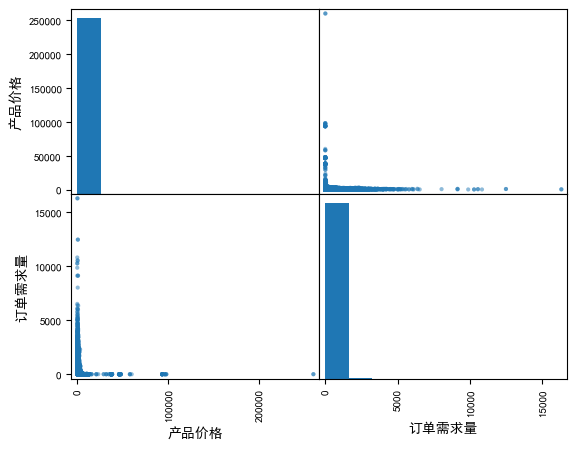

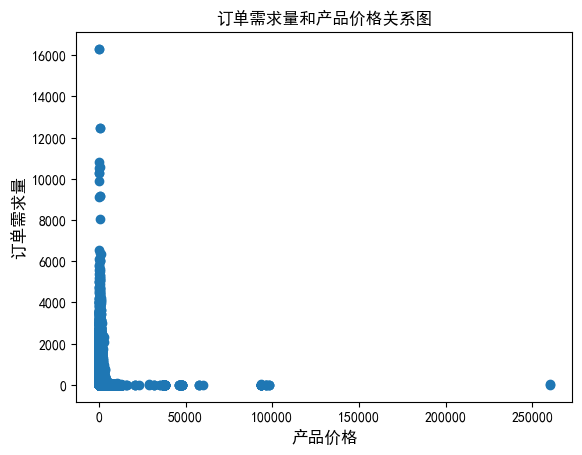

In [6]:
#绘制价格和需求量的散点图矩阵，直观感受价格和需求量的关系，发现两个变量的分布在图像中呈现近似L型分布，从直方图中可以看出大部分产
#品价格处于中低价位，且需求量大，只有少量数据处于高价位且需求量很少
price_and_require=data[['产品价格','订单需求量']]
price_and_require
pd.plotting.scatter_matrix(price_and_require)
plt.show()
plt.plot(data['产品价格'], data['订单需求量'],'o')
plt.xlabel('产品价格',fontsize=12)
plt.ylabel('订单需求量',fontsize=12)
plt.title('订单需求量和产品价格关系图',fontsize=12)
plt.show()

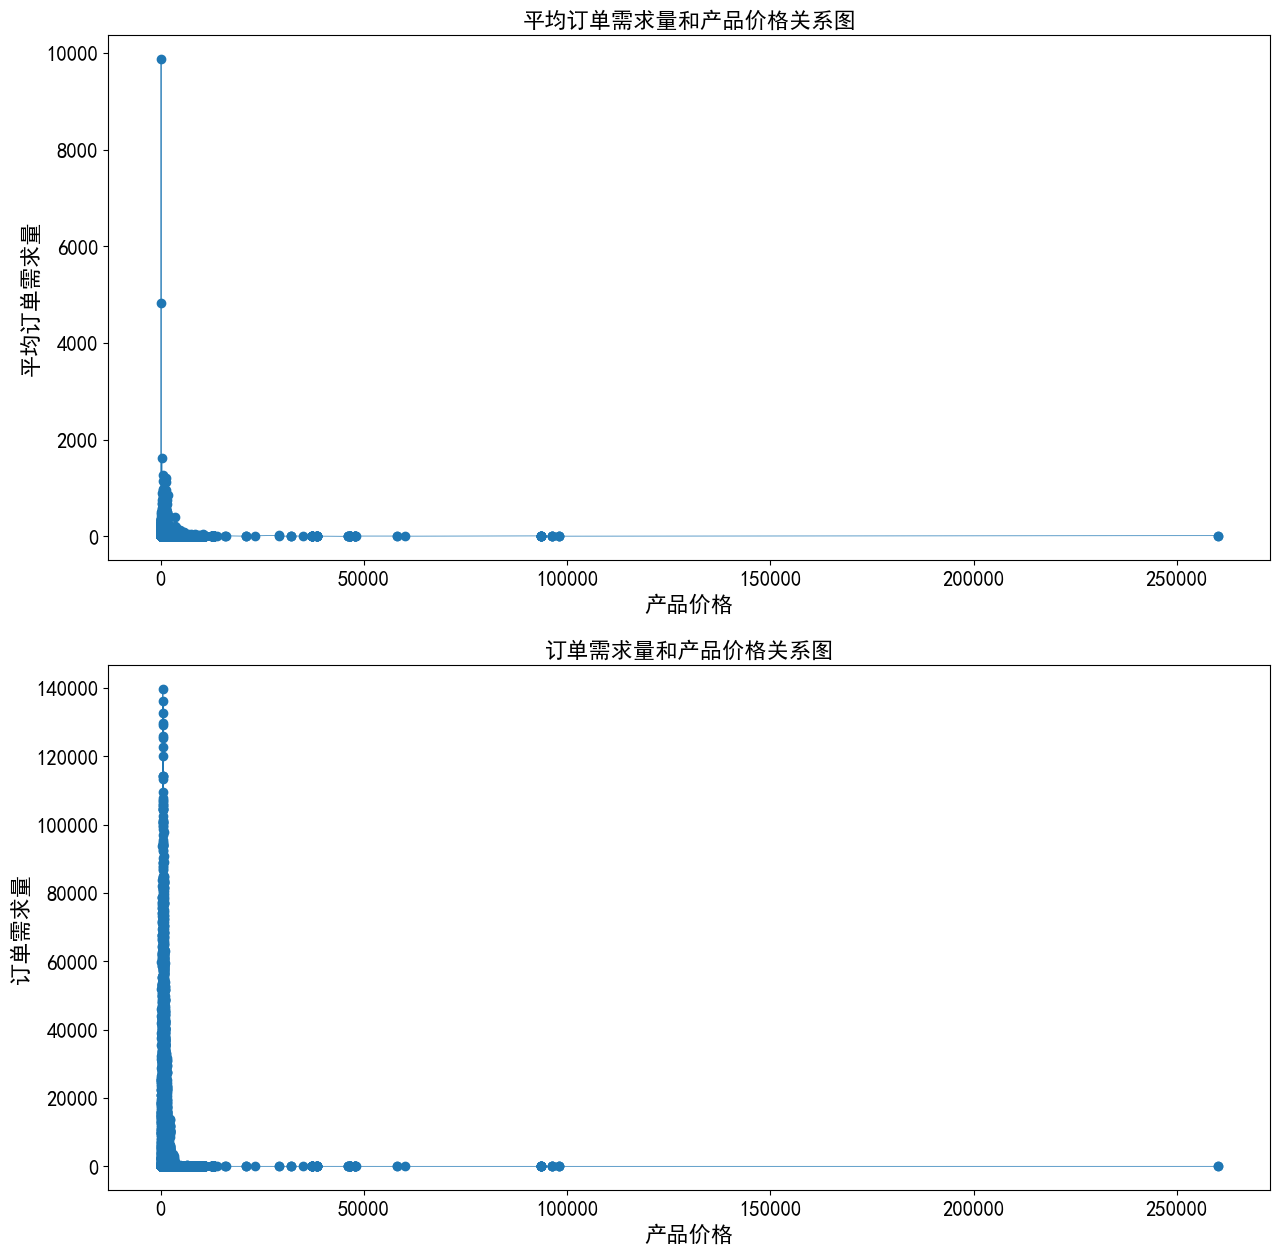

            产品价格      订单需求量
0           1.00  12.571429
1           1.01   6.352941
2           2.00  16.545455
3           2.01   7.157895
4           3.00  11.666667
...          ...        ...
14360   98002.00   4.000000
14361   98005.00   6.000000
14362   98016.00   5.000000
14363  260006.00  15.000000
14364  260014.00   9.000000

[14365 rows x 2 columns]
            产品价格  订单需求量
0           1.00     88
1           1.01    108
2           2.00    182
3           2.01    136
4           3.00    175
...          ...    ...
14360   98002.00      4
14361   98005.00      6
14362   98016.00      5
14363  260006.00     15
14364  260014.00      9

[14365 rows x 2 columns]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.0, 366.74, 602.74, 801.6300000000001, 1024.7600000000002, 1305.0, 1679.8680000000004, 2217.95, 2933.2186666000002, 4310.6]


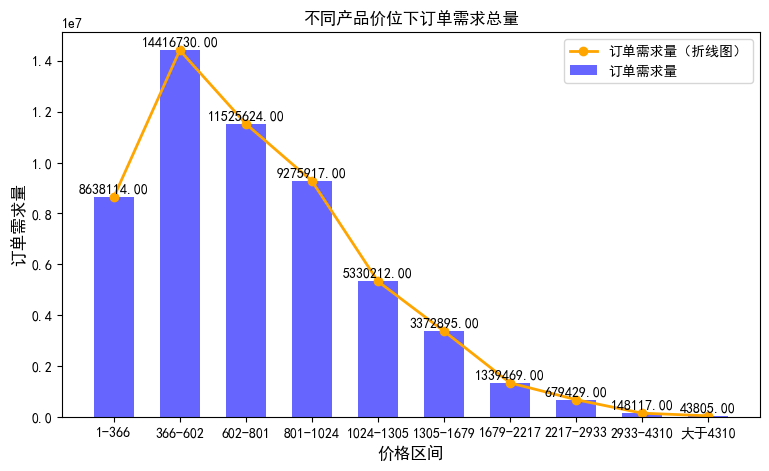

In [7]:
# 按照产品价格分组，并计算需求量平均值，发现有14365种价格，和整体分布相似，该分布也呈现近似L型分布
grouped_ave = data.groupby('产品价格')['订单需求量'].mean().reset_index()
grouped_sum = data.groupby('产品价格')['订单需求量'].sum().reset_index()
p = plt.figure(figsize=(15, 15))
ax1 = p.add_subplot(2, 1, 1)
ax2 = p.add_subplot(2, 1, 2)
# plt.figure(figsize=(10, 6))
ax1.plot(grouped_ave['产品价格'], grouped_ave['订单需求量'],'o-',linewidth=0.5)
ax1.set_xlabel('产品价格',fontsize=16)
ax1.set_ylabel('平均订单需求量',fontsize=16)
ax1.set_title('平均订单需求量和产品价格关系图',fontsize=16)
# plt.show()
#plt.savefig('img/1.png',dpi=300)
ax2.plot(grouped_sum['产品价格'], grouped_sum['订单需求量'],'o-',linewidth=0.5)
ax2.set_xlabel('产品价格',fontsize=16)
ax2.set_ylabel('订单需求量',fontsize=16)
ax2.set_title('订单需求量和产品价格关系图',fontsize=16)
ax1.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
plt.show()
print(grouped_ave)
print(grouped_sum)
#计算分位数
fenweidian=np.arange(0,1,0.1)
q=[]
print(fenweidian)
for i in fenweidian:
    q.append(grouped_sum['产品价格'].quantile(i))
print(q)

#连续数据离散化
bins = [0., 366., 602., 801., 1024., 1305., 1679., 2217., 2933., 4310.,float('inf')]#左开右闭
# 将价格分到区间中
grouped_sum['price_bins'] = pd.cut(grouped_sum['产品价格'], bins=bins, labels=['1-366', '366-602', '602-801','801-1024','1024-1305'
                                                                           ,'1305-1679','1679-2217','2217-2933','2933-4310','大于4310'])

# 计算每个区间的订单总和
demand_sum = grouped_sum.groupby('price_bins')['订单需求量'].sum()
plt.figure(figsize=(9, 5))
# 绘制柱状图
plt.bar(demand_sum.index, demand_sum.values, width=0.6,color='blue', label='订单需求量', alpha=0.6)

# 绘制折线图
plt.plot(demand_sum.index, demand_sum.values ,'-o',color='orange', label='订单需求量（折线图）',linewidth=2)

for x, y in zip(demand_sum.index, demand_sum.values):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,3), ha='center')
# 添加标签和标题
plt.xlabel('价格区间',fontsize=12)
plt.ylabel('订单需求量',fontsize=12)
plt.title('不同产品价位下订单需求总量',fontsize=12)
# 显示图例
plt.legend()
# 显示图形
plt.show()

pearson系数： -0.12076275373596743
   P-Value： 0.0
spearmanr系数： -0.2946295939943642
   P-Value： 0.0


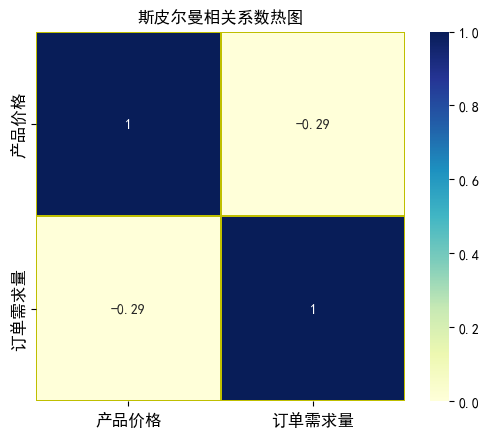

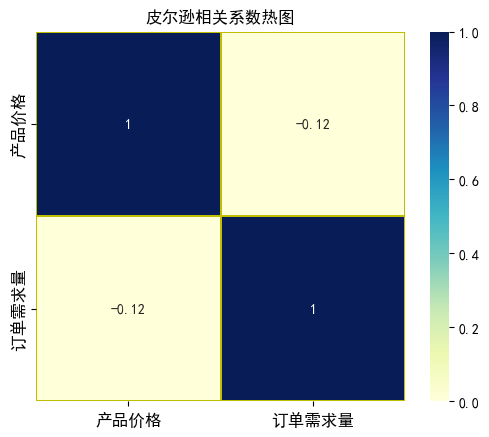

In [7]:
#进行相关性分析，发现价格和需求量呈现不明显的负线性相关关系，因此线性回归模型不适合探究两数据之间的关系
#所以针对第一问我们采用基于统计的建模分析
r1 = pearsonr(price_and_require['产品价格'],price_and_require['订单需求量'])
print("pearson系数：",r1[0])
print("   P-Value：",r1[1])
r2 = spearmanr(price_and_require['产品价格'],price_and_require['订单需求量'])
print("spearmanr系数：",r2[0])
print("   P-Value：",r2[1])
heatmap_spearman=sns.heatmap(price_and_require.corr(method='spearman'),annot=True, vmax=1, vmin=0, xticklabels=True, yticklabels=True, square=True, cmap="YlGnBu",
            linewidths=0.05, linecolor='y')  # mask=t < 0.8等价于mask=(t < 0.8)
plt.title('斯皮尔曼相关系数热图', fontsize=12)  # 添加图表标题“变量相关系数 - 热图”,fontsize=18 字体大小 可省略
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
heatmap_pearson=sns.heatmap(price_and_require.corr(method='pearson'),annot=True, vmax=1, vmin=0, xticklabels=True, yticklabels=True, square=True, cmap="YlGnBu",
            linewidths=0.05, linecolor='y')  # mask=t < 0.8等价于mask=(t < 0.8)
plt.title('皮尔逊相关系数热图', fontsize=12)  # 添加图表标题“变量相关系数 - 热图”,fontsize=18 字体大小 可省略
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 基于统计分析的建模

In [8]:
data[['产品价格','订单需求量']].describe()#首先进行数据基本量的统计描述

,产品价格,订单需求量
count,597382.000000,597382.000000
mean,1076.141512,91.683901
std,1167.576590,199.887129
min,1.000000,1.000000
25%,598.000000,10.000000
50%,883.000000,29.000000
75%,1291.000000,101.000000
max,260014.000000,16308.000000


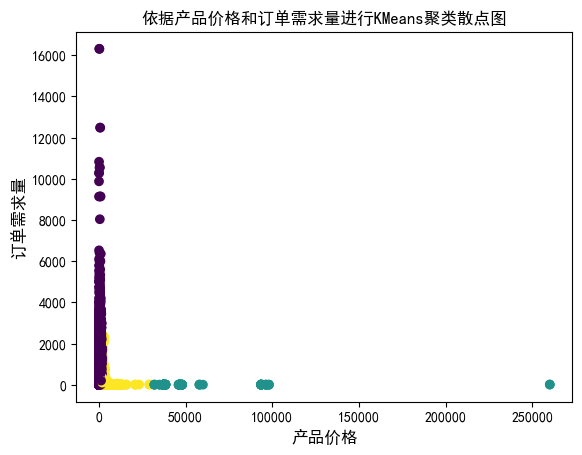

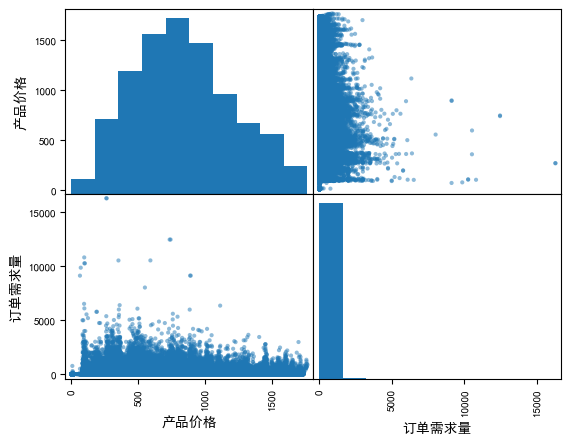

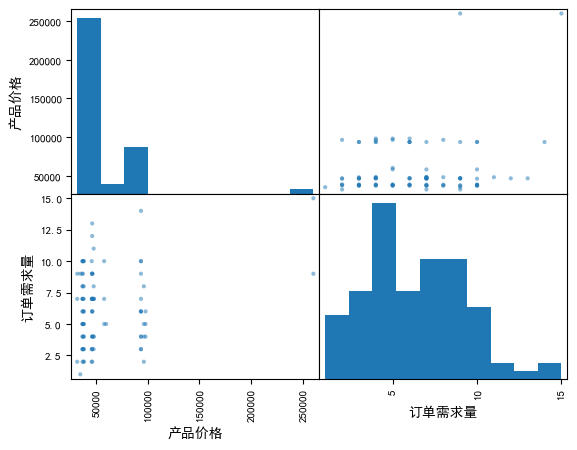

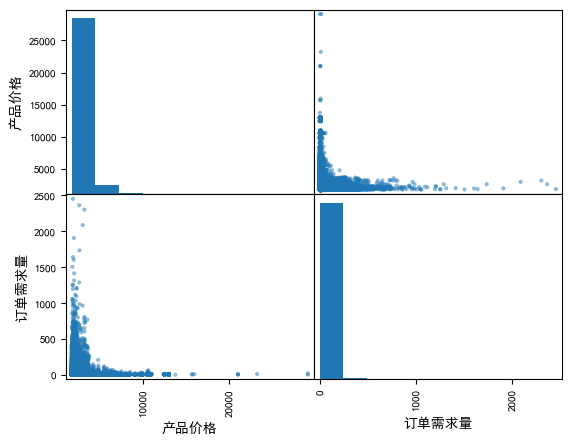

In [9]:
#使用kmeans算法对产品价格和订单需求量进行聚类
k_means_X = data[['产品价格','订单需求量']].to_numpy()
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(k_means_X)
y_kmeans = kmeans.predict(k_means_X)
k_means_scatter=plt.scatter(k_means_X[:, 0], k_means_X[:, 1], c=y_kmeans)
plt.xlabel('产品价格',fontsize=12)
plt.ylabel('订单需求量',fontsize=12)
plt.title('依据产品价格和订单需求量进行KMeans聚类散点图',fontsize=12)
plt.show()

#将原始数据和簇分配合并
clusters = pd.DataFrame({'cluster': y_kmeans}, index=data.index)
clustered_data = pd.concat([data, clusters], axis=1)

#遍历每个簇，将数据保存到单独的CSV文件中
for cluster_id in range(k):
     cluster_data = clustered_data[clustered_data['cluster'] == cluster_id]
     cluster_data.to_csv(f'cluster_unique{cluster_id}.csv', index=False)
data_0 = pd.read_csv('./cluster_unique0.csv')
data_1 = pd.read_csv('./cluster_unique1.csv')
data_2 = pd.read_csv('./cluster_unique2.csv')

#展示不同类别下的价格和需求量的关系
for i in range(3):
    temp_data=pd.read_csv('./cluster_unique{}.csv'.format(i))
    jiage_and_xuqiuliang=temp_data[['产品价格','订单需求量']]
    pd.plotting.scatter_matrix(jiage_and_xuqiuliang)
    plt.show()

In [10]:
data_0[['产品价格','订单需求量']].describe()

,产品价格,订单需求量
count,522642.000000,522642.00000
mean,842.996254,100.97001
std,373.577137,210.93598
min,1.000000,1.00000
25%,553.000000,11.00000
50%,809.000000,35.00000
75%,1100.000000,105.00000
max,1768.000000,16308.00000


In [11]:
data_1[['产品价格','订单需求量']].describe()

,产品价格,订单需求量
count,96.000000,96.000000
mean,57198.641667,6.260417
std,36831.866277,2.928067
min,32003.000000,1.000000
25%,37219.000000,4.000000
50%,46506.000000,6.000000
75%,58016.000000,8.250000
max,260014.000000,15.000000


In [12]:
data_2[['产品价格','订单需求量']].describe()

,产品价格,订单需求量
count,74644.000000,74644.000000
mean,2636.397445,26.774329
std,1157.796586,58.291670
min,1737.400000,1.000000
25%,2013.000000,7.000000
50%,2312.000000,11.000000
75%,2752.000000,24.000000
max,29118.000000,2452.000000


In [14]:
pierxun_0 = pearsonr(data_0['产品价格'],data_0['订单需求量'])
print("pearson系数：",pierxun_0[0])
print("   P-Value：",pierxun_0[1])
pierxun_1 = pearsonr(data_1['产品价格'],data_1['订单需求量'])
print("pearson系数：",pierxun_1[0])
print("   P-Value：",pierxun_1[1])
pierxun_2 = pearsonr(data_2['产品价格'],data_2['订单需求量'])
print("pearson系数：",pierxun_2[0])
print("   P-Value：",pierxun_2[1])

pearson系数： -0.17271120062380765
   P-Value： 0.0
pearson系数： 0.23909881278125394
   P-Value： 0.018969476459193054
pearson系数： -0.11406995793212116
   P-Value： 1.3242245524734817e-214


C:\Users\86136\AppData\Local\Temp\ipykernel_15604\1680658431.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_bins'] = pd.cut(data['产品价格'], bins=bins, labels=['1-1737', '1737-29118', '32003-260014'])


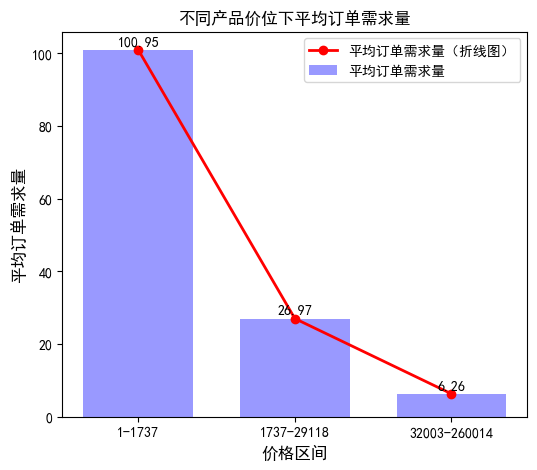

In [15]:
# 自定义价格区间
bins = [1, 1737, 29118, float('inf')]

# 将价格分到区间中
data['price_bins'] = pd.cut(data['产品价格'], bins=bins, labels=['1-1737', '1737-29118', '32003-260014'])

# 计算每个区间的平均订单需求量
demand_means = data.groupby('price_bins')['订单需求量'].mean()
plt.figure(figsize=(6, 5))
# 绘制柱状图
plt.bar(demand_means.index, demand_means.values, width=0.7,color='blue', label='平均订单需求量', alpha=0.4)

# 绘制折线图
plt.plot(demand_means.index, demand_means.values ,'-o',color='red', label='平均订单需求量（折线图）',linewidth=2)

for x, y in zip(demand_means.index, demand_means.values):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,3), ha='center')
# 添加标签和标题
plt.xlabel('价格区间',fontsize=12)
plt.ylabel('平均订单需求量',fontsize=12)
plt.title('不同产品价位下平均订单需求量',fontsize=12)
# 显示图例
plt.legend()
# 显示图形
plt.show()
#可以看出随着价格的升高，平均订单需求量逐步降低，说明高价位由于

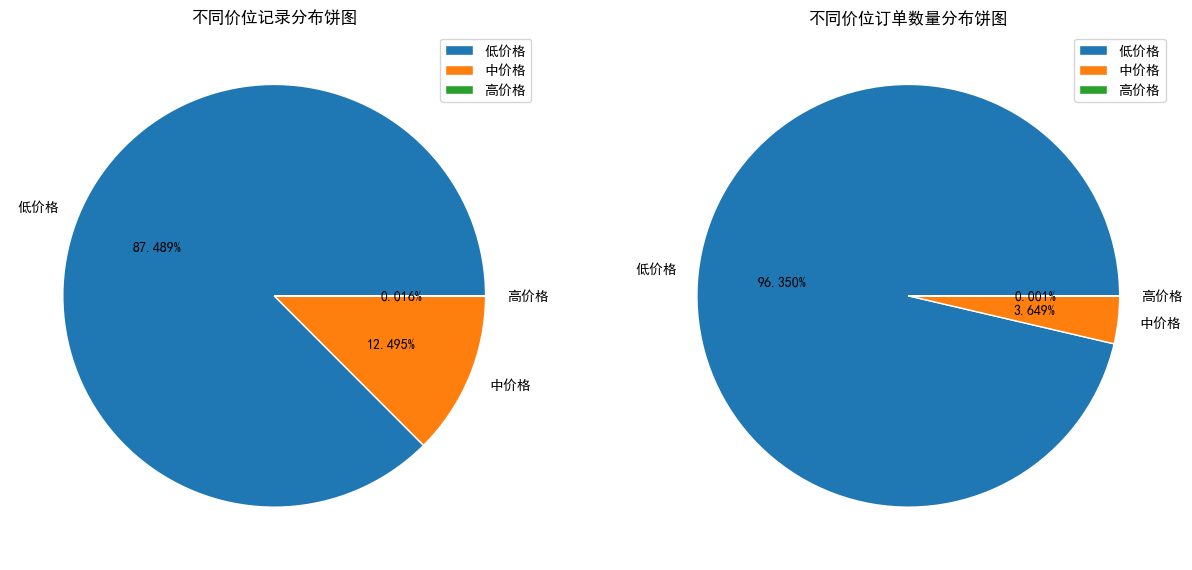

In [17]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # 同时显示数值和占比的饼图
        return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
p = plt.figure(figsize=(15, 15))
ax1 = p.add_subplot(1, 2, 1)
ax2 = p.add_subplot(1, 2, 2)
# plt.figure(figsize=(5, 5))
numbers=[data_0['订单需求量'].count(),data_2['订单需求量'].count(),data_1['订单需求量'].count()]
need=[data_0['订单需求量'].sum(),data_2['订单需求量'].sum(),data_1['订单需求量'].sum()]
ax1.pie(numbers, labels=['低价格','中价格','高价格'], wedgeprops={'linewidth': 1, 'edgecolor': 'white'},autopct='%1.3f%%')
ax1.set_title("不同价位记录分布饼图")
ax1.legend(['低价格','中价格','高价格'])

ax2.pie(need, labels=['低价格','中价格','高价格'], wedgeprops={'linewidth': 1, 'edgecolor': 'white'},autopct='%1.3f%%')
ax2.set_title("不同价位订单数量分布饼图")
ax2.legend(['低价格','中价格','高价格'])

## 区域对需求量的影响

In [18]:
#对数据进行正态性检验 
from scipy.stats import normaltest
import numpy as np
statistic, p_value = normaltest(data['订单需求量'])

# 输出检验结果
print("Statistic:", statistic)
print("P-value:", p_value)
if p_value < 0.05:
    print("数据不符合正态分布")
else:
    print("数据符合正态分布")


Statistic: 1005876.6584558439
P-value: 0.0
数据不符合正态分布


In [19]:
data.groupby('销售区域编码')['订单需求量'].agg(['max', 'min', 'mean','sum','count'])
from scipy.stats import kruskal

# 使用kruskal函数进行Kruskal-Wallis检验
statistic, p_value = kruskal(data[data['销售区域编码'] == 101]['订单需求量'],
                             data[data['销售区域编码'] == 102]['订单需求量'],
                             data[data['销售区域编码'] == 103]['订单需求量'],
                             data[data['销售区域编码'] == 104]['订单需求量'],
                             data[data['销售区域编码'] == 105]['订单需求量'])

# 打印结果
print('统计量：', statistic)
print('P值：', p_value)


统计量： 3927.075571844587
P值： 0.0


In [20]:
data.groupby(['销售区域编码'])['订单需求量'].agg(['max', 'min', 'mean','sum','count','median','std'])

,max,min,mean,sum,count,median,std
销售区域编码,,,,,,,
101,16301,1,98.542235,12400949,125844,33.0,233.213446
102,5055,1,85.298599,13966622,163738,33.0,154.031230
103,9140,1,99.190436,11519878,116139,32.0,210.304888
104,9874,1,95.284055,2387342,25055,34.0,190.206931
105,16308,1,87.004796,14495521,166606,21.0,206.042987


Text(0.5, 1.0, '不同地区需求量饼状图')

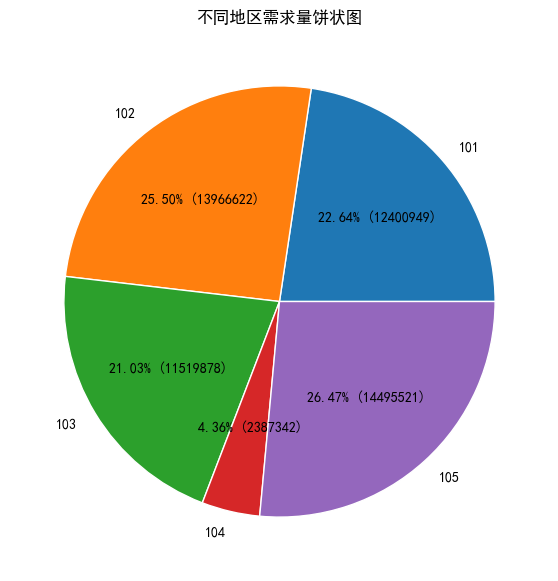

In [21]:
plt.figure(figsize=(7, 7))
sum_need=[data.groupby(['销售区域编码'])['订单需求量'].sum()[101]
          ,data.groupby(['销售区域编码'])['订单需求量'].sum()[102]
          ,data.groupby(['销售区域编码'])['订单需求量'].sum()[103]
          ,data.groupby(['销售区域编码'])['订单需求量'].sum()[104]
          ,data.groupby(['销售区域编码'])['订单需求量'].sum()[105]]
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # 同时显示数值和占比的饼图
        return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(sum_need, labels=['101','102','103','104','105'],wedgeprops={'linewidth': 1, 'edgecolor': 'white'},autopct=make_autopct(sum_need),startangle=0 )
plt.title("不同地区需求量饼状图")
# plt.legend(['101','102','103','104','105'])

Text(0.5, 1.0, '不同销售区域订单需求量标准差')

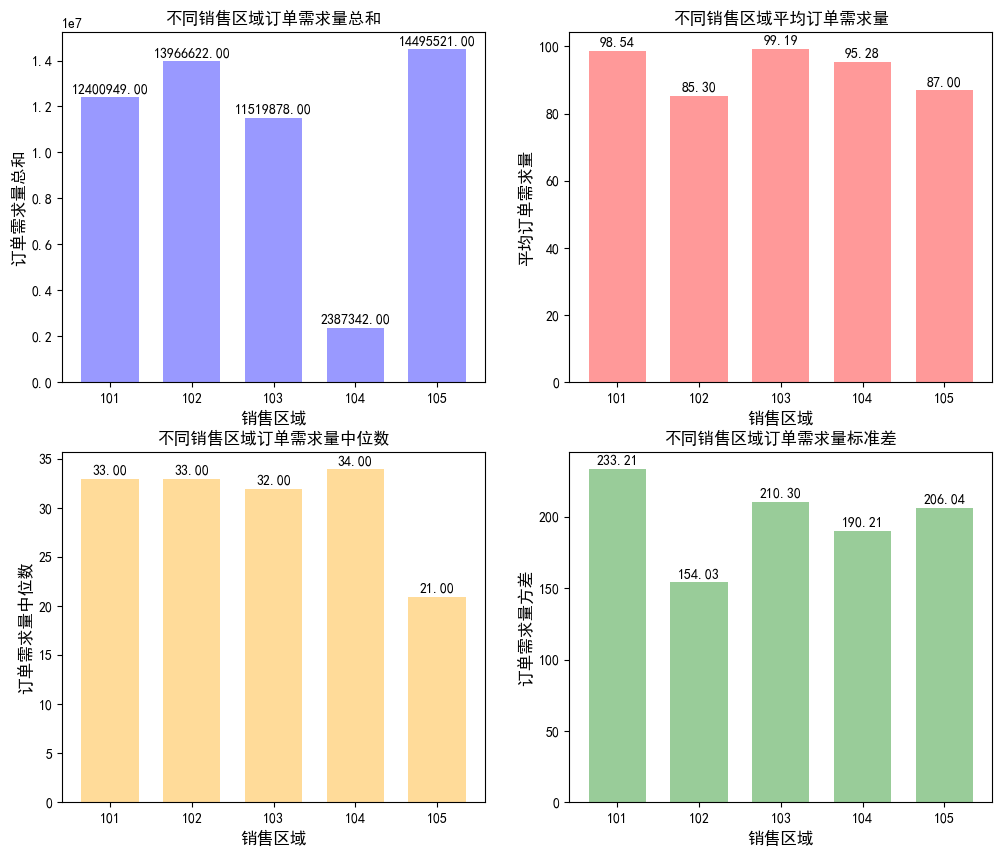

In [22]:
p=plt.figure(figsize=(12, 10))
# 绘制柱状图
ax1 = p.add_subplot(2, 2, 1)
ax2 = p.add_subplot(2, 2, 2)
ax3 = p.add_subplot(2, 2, 3)
ax4 = p.add_subplot(2, 2, 4)
ax1.bar(data.groupby(['销售区域编码'])['订单需求量'].sum().index, data.groupby(['销售区域编码'])['订单需求量'].sum().values, width=0.7,color='blue', label='订单需求量', alpha=0.4)
for x, y in zip(data.groupby(['销售区域编码'])['订单需求量'].sum().index, data.groupby(['销售区域编码'])['订单需求量'].sum().values):
    label = "{:.2f}".format(y)
    ax1.annotate(label, (x, y), textcoords="offset points", xytext=(0,3), ha='center')
# 添加标签和标题
ax1.set_xlabel('销售区域',fontsize=12)
ax1.set_ylabel('订单需求量总和',fontsize=12)
ax1.set_title('不同销售区域订单需求量总和',fontsize=12)

# 绘制柱状图
ax2.bar(data.groupby(['销售区域编码'])['订单需求量'].mean().index, data.groupby(['销售区域编码'])['订单需求量'].mean().values, width=0.7,color='red', label='订单需求量', alpha=0.4)
for x, y in zip(data.groupby(['销售区域编码'])['订单需求量'].mean().index, data.groupby(['销售区域编码'])['订单需求量'].mean().values):
    label = "{:.2f}".format(y)
    ax2.annotate(label, (x, y), textcoords="offset points", xytext=(0,3), ha='center')
# 添加标签和标题
ax2.set_xlabel('销售区域',fontsize=12)
ax2.set_ylabel('平均订单需求量',fontsize=12)
ax2.set_title('不同销售区域平均订单需求量',fontsize=12)

ax3.bar(data.groupby(['销售区域编码'])['订单需求量'].median().index, data.groupby(['销售区域编码'])['订单需求量'].median().values, width=0.7,color='orange', label='订单需求量', alpha=0.4)
for x, y in zip(data.groupby(['销售区域编码'])['订单需求量'].median().index, data.groupby(['销售区域编码'])['订单需求量'].median().values):
    label = "{:.2f}".format(y)
    ax3.annotate(label, (x, y), textcoords="offset points", xytext=(0,3), ha='center')
# 添加标签和标题
ax3.set_xlabel('销售区域',fontsize=12)
ax3.set_ylabel('订单需求量中位数',fontsize=12)
ax3.set_title('不同销售区域订单需求量中位数',fontsize=12)

ax4.bar(data.groupby(['销售区域编码'])['订单需求量'].std().index, data.groupby(['销售区域编码'])['订单需求量'].std().values, width=0.7,color='green', label='订单需求量', alpha=0.4)
for x, y in zip(data.groupby(['销售区域编码'])['订单需求量'].std().index, data.groupby(['销售区域编码'])['订单需求量'].std().values):
    label = "{:.2f}".format(y)
    ax4.annotate(label, (x, y), textcoords="offset points", xytext=(0,3), ha='center')
# 添加标签和标题
ax4.set_xlabel('销售区域',fontsize=12)
ax4.set_ylabel('订单需求量方差',fontsize=12)
ax4.set_title('不同销售区域订单需求量标准差',fontsize=12)

In [23]:
data.groupby(['销售区域编码','年'])['订单需求量'].sum()

销售区域编码  年   
101     2015    1052801
        2016    2887262
        2017    4380096
        2018    4080790
102     2015    1328756
        2016    3586498
        2017    4857521
        2018    4193847
103     2015     722594
        2016    2282135
        2017    4059617
        2018    4455532
104     2015     450856
        2016    1936486
105     2015     591862
        2016    2977618
        2017    6183644
        2018    4742397
Name: 订单需求量, dtype: int64

Text(0.5, 0, '区域')

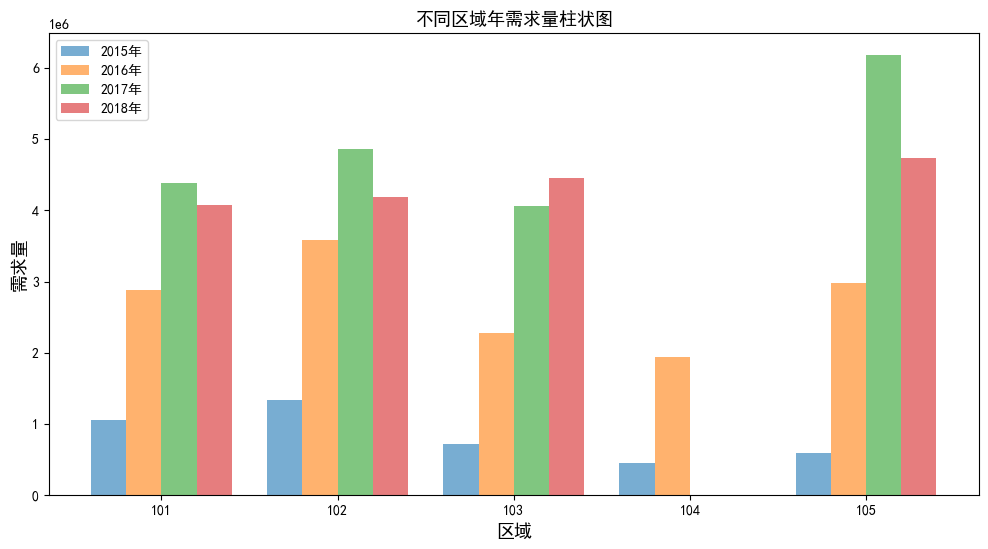

In [24]:
width = 0.2 # 每个柱形图的宽度
data_2015=[1052801,1328756,722594,450856,591862]
data_2016=[2887262,3586498,2282135,1936486,2977618]
data_2017=[4380096,4857521,4059617,0,6183644]
data_2018=[4080790,4193847,4455532,0,4742397]
x = np.arange(5)-0.25/2 # x 轴位置
plt.figure(figsize=(12,6))
plt.bar(x - 2*width+0.2/2, data_2015, width=width, alpha=0.6, label='2015年')

plt.bar(x-width+0.2/2, data_2016, width=width, alpha=0.6, label='2016年')

plt.bar(x+0.2/2, data_2017, width=width, alpha=0.6, label='2017年')

plt.bar(x+width+0.2/2, data_2018, width=width, alpha=0.6, label='2018年')

plt.xticks(x,['101','102','103','104','105'])

# plt.xticklabels(['101','102','103','104','105'])

plt.legend()

plt.title("不同区域年需求量柱状图",fontsize=13)

plt.ylabel("需求量",fontsize=13)

plt.xlabel("区域",fontsize=13)

In [25]:
temp=data.groupby(['销售区域编码','产品大类编码'])['订单需求量'].agg(['count','sum','mean'])
temp

count      sum        mean
销售区域编码 产品大类编码                            
101    301      1294    51961   40.155332
       302     13229   764899   57.819865
       303     19737   972525   49.274206
       304       419    10281   24.536993
       305     20343  2077417  102.119501
       306     54474  6256725  114.857088
       307      7473  1113233  148.967349
       308      8875  1153908  130.017803
102    301      3704   223807   60.423056
       302     29336  1588181   54.137612
       303     24656   881604   35.756165
       304       799    17876   22.372966
       305     20378  1496401   73.432182
       306     63129  7249414  114.834925
       307     10263  1145400  111.604794
       308     11473  1363939  118.882507
103    301      2412   166150   68.884743
       302     25305  2005697   79.260897
       303     17006  1123096   66.041162
       304       653    17335   26.546708
       305     11861   801865   67.605177
       306     41735  5230489  125.326201
       307      8232  1093165  132.794582
       308      8935  1082081  121.105876
104    301      5637   489227   86.788540
       304      2093   100259   47.902054
       307      9273   953968  102.875876
       308      8052   843888  104.804769
105    301      8411   655578   77.942932
       302     26869  1862557   69.319923
       303     10432   770800   73.888037
       304      6026   472693   78.442250
       305     22564  1948573   86.357605
       306     59986  5811809   96.886090
       307     15602  1422930   91.201769
       308     16716  1550581   92.760290

489227


Text(0.5, 0, '区域')

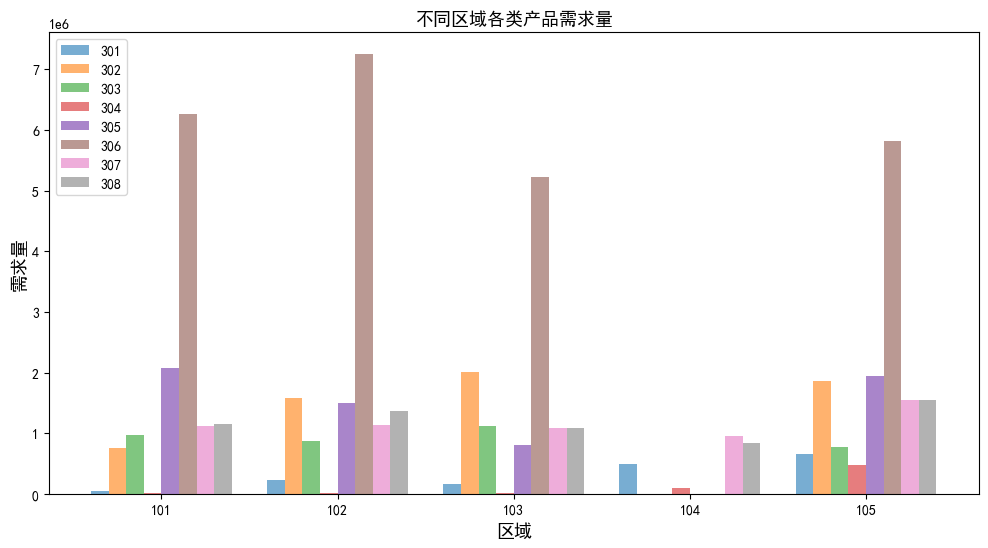

In [26]:
print(temp.loc[(104, 301), 'sum'])
width = 0.1 # 每个柱形图的宽度
data_301=[temp.loc[(101, 301), 'sum'],temp.loc[(102, 301), 'sum'],temp.loc[(103, 301), 'sum'],temp.loc[(104, 301), 'sum'],temp.loc[(105, 301), 'sum']]
data_302=[temp.loc[(101, 302), 'sum'],temp.loc[(102, 302), 'sum'],temp.loc[(103, 302), 'sum'],0,temp.loc[(105, 302), 'sum']]
data_303=[temp.loc[(101, 303), 'sum'],temp.loc[(102, 303), 'sum'],temp.loc[(103, 303), 'sum'],0,temp.loc[(105, 303), 'sum']]
data_304=[temp.loc[(101, 304), 'sum'],temp.loc[(102, 304), 'sum'],temp.loc[(103, 304), 'sum'],temp.loc[(104, 304), 'sum'],temp.loc[(105, 304), 'sum']]
data_305=[temp.loc[(101, 305), 'sum'],temp.loc[(102, 305), 'sum'],temp.loc[(103, 305), 'sum'],0,temp.loc[(105, 305), 'sum']]
data_306=[temp.loc[(101, 306), 'sum'],temp.loc[(102, 306), 'sum'],temp.loc[(103, 306), 'sum'],0,temp.loc[(105, 306), 'sum']]
data_307=[temp.loc[(101, 307), 'sum'],temp.loc[(102, 307), 'sum'],temp.loc[(103, 307), 'sum'],temp.loc[(104, 307), 'sum'],temp.loc[(105, 308), 'sum']]
data_308=[temp.loc[(101, 308), 'sum'],temp.loc[(102, 308), 'sum'],temp.loc[(103, 308), 'sum'],temp.loc[(104, 308), 'sum'],temp.loc[(105, 308), 'sum']]

x = np.arange(5) # x 轴位置
plt.figure(figsize=(12,6))
plt.bar(x - 4*width, data_301, width=width, alpha=0.6, label='301')
plt.bar(x-3*width, data_302, width=width, alpha=0.6, label='302')
plt.bar(x-2*width, data_303, width=width, alpha=0.6, label='303')
plt.bar(x-width, data_304, width=width, alpha=0.6, label='304')
plt.bar(x , data_305, width=width, alpha=0.8, label='305')
plt.bar(x+width, data_306, width=width, alpha=0.6, label='306')
plt.bar(x+2*width, data_307, width=width, alpha=0.6, label='307')
plt.bar(x+3*width, data_308, width=width, alpha=0.6, label='308')

plt.xticks(x-0.05,['101','102','103','104','105'])

# plt.xticklabels(['101','102','103','104','105'])

plt.legend()

plt.title("不同区域各类产品需求量",fontsize=13)

plt.ylabel("需求量",fontsize=13)

plt.xlabel("区域",fontsize=13)

In [27]:
temp=data.groupby(['销售区域编码','销售渠道名称'])['订单需求量'].agg(['mean','sum','count'])
temp

mean       sum   count
销售区域编码 销售渠道名称                              
101    0       128.687565    860019    6683
       1        96.851571  11540930  119161
102    0        93.668246    335988    3587
       1        85.111139  13630634  160151
103    0       146.215633   1348693    9224
       1        95.133377  10171185  106915
104    0       100.342792   2256007   22483
       1        51.063375    131335    2572
105    0       111.869901  13003198  116235
       1        29.626630   1492323   50371

131335


Text(0.5, 0, '区域')

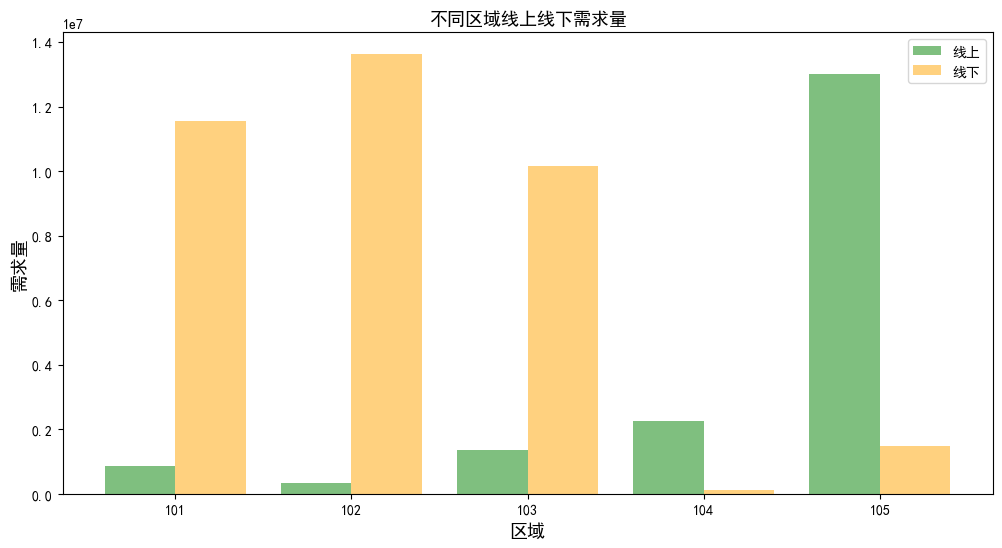

In [28]:
print(temp.loc[(104, 1), 'sum'])
width = 0.4 # 每个柱形图的宽度
data_online=[temp.loc[(101, 0), 'sum'],temp.loc[(102, 0), 'sum'],temp.loc[(103, 0), 'sum'],temp.loc[(104, 0), 'sum'],temp.loc[(105, 0), 'sum']]
data_offline=[temp.loc[(101, 1), 'sum'],temp.loc[(102, 1), 'sum'],temp.loc[(103, 1), 'sum'],temp.loc[(104, 1), 'sum'],temp.loc[(105, 1), 'sum']]

x = np.arange(5) # x 轴位置
plt.figure(figsize=(12,6))
plt.bar(x-width, data_online, width=width, alpha=0.5, color='green',label='线上')
plt.bar(x, data_offline, width=width, alpha=0.5,color='orange', label='线下')

plt.xticks(x-width/2,['101','102','103','104','105'])

# plt.xticklabels(['101','102','103','104','105'])

plt.legend()

plt.title("不同区域线上线下需求量",fontsize=13)

plt.ylabel("需求量",fontsize=13)

plt.xlabel("区域",fontsize=13)